2

In [4]:
import numpy as np
import scipy
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt


class LagrangeInterpolator:

    def __init__(self, xk, yk):
        self.xk = np.asarray(xk, dtype=float)
        self.yk = np.asarray(yk, dtype=float)

    def __call__(self, x):
        P = 0
        for i in range(len(self.yk)):
            lk = 1
            for j in range(len(self.xk)):
                if j != i:
                    lk *= (x - self.xk[j]) / (self.xk[i] - self.xk[j])
            P += lk * self.yk[i]
        return P

In [5]:
with np.load("data_7_1.npz") as data:
    x1, y1 = data["x1"], data["y1"]

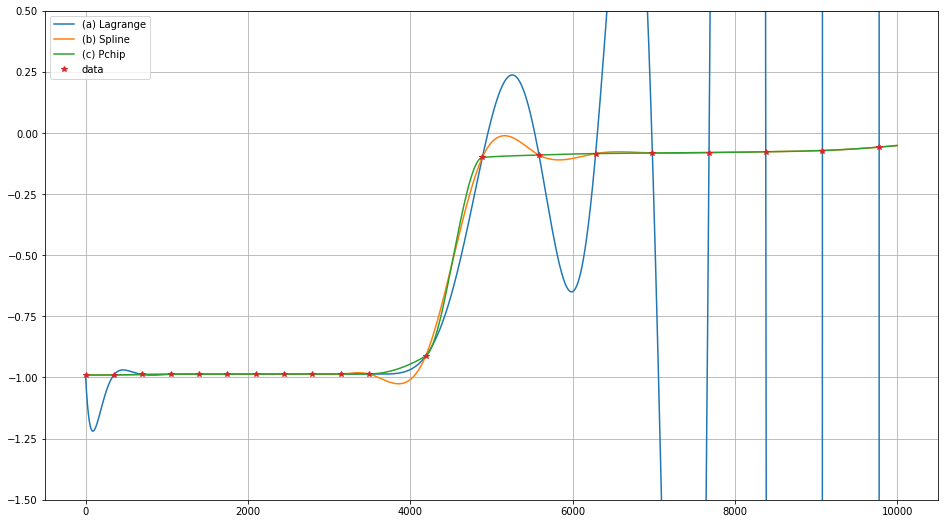

In [23]:
xx = np.linspace(0, 10000, 20000)
lagr = [LagrangeInterpolator(x1, y1)(val) for val in xx]
plt.figure(figsize=(16, 9))
plt.plot(xx, lagr, label="(a) Lagrange")
cubic_spline = scipy.interpolate.CubicSpline(x1, y1)
plt.plot(xx, cubic_spline(xx), label="(b) Spline")
pchipInterpolator = scipy.interpolate.PchipInterpolator(x1, y1)
plt.plot(xx, pchipInterpolator(xx), label="(c) Pchip")
plt.plot(x1, y1, "*", label="data")
plt.ylim(-1.5, 0.5)
plt.legend(loc='best')
plt.grid(True)
plt.show()

3

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


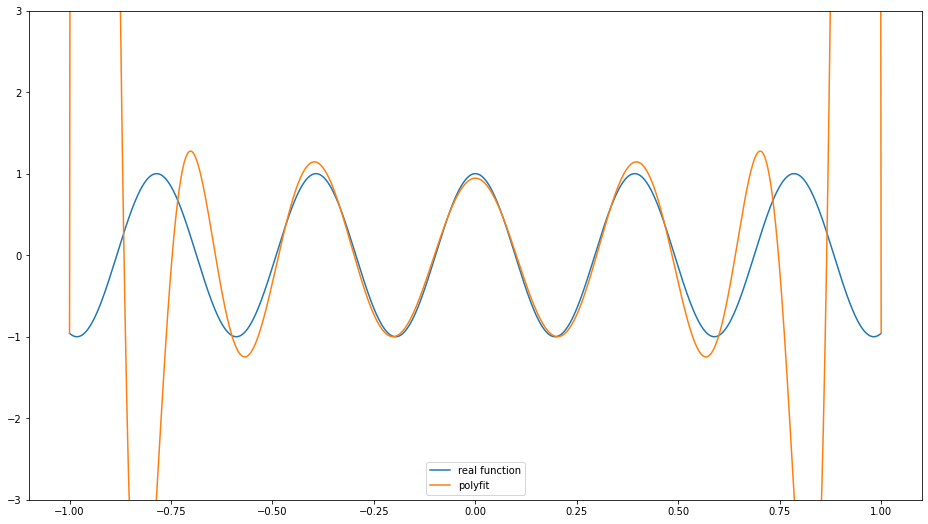

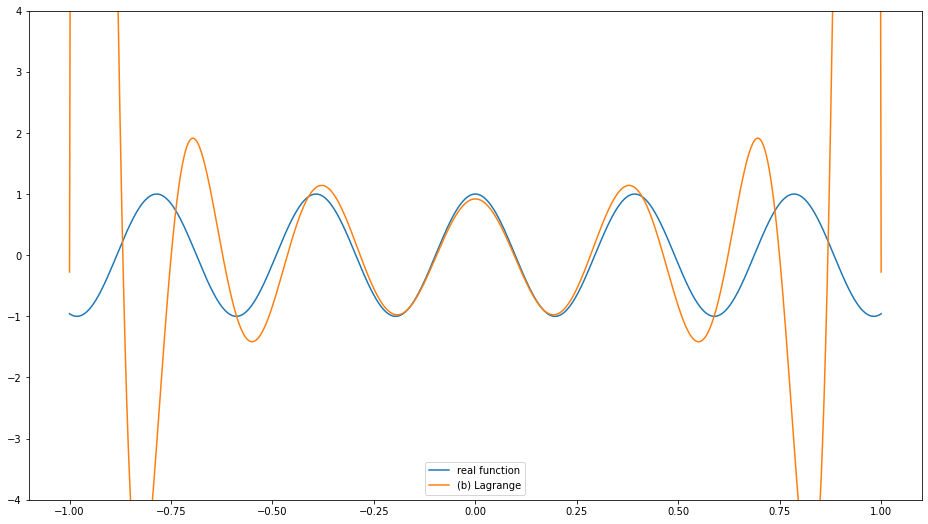

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


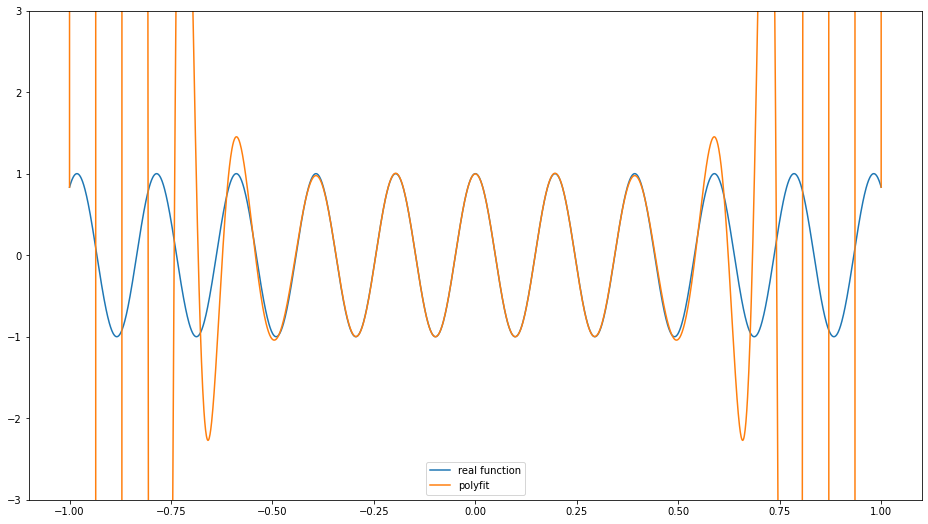

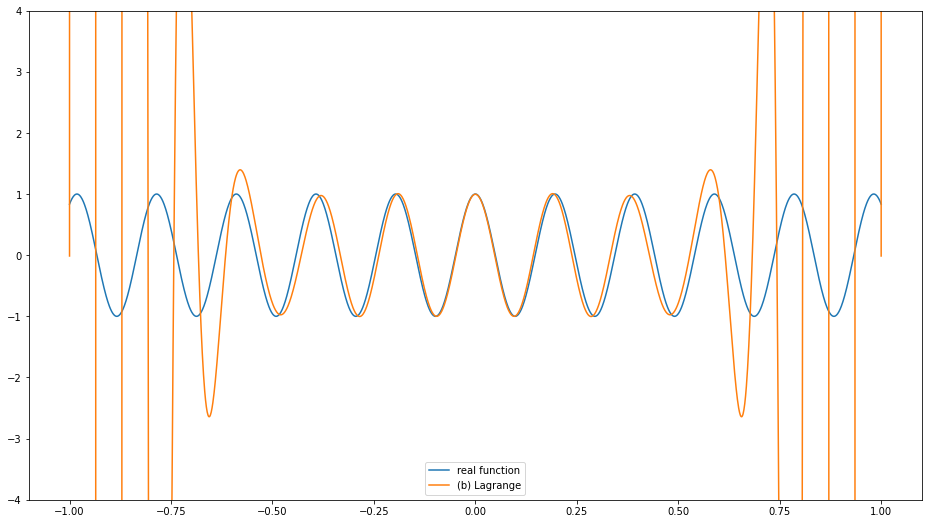

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


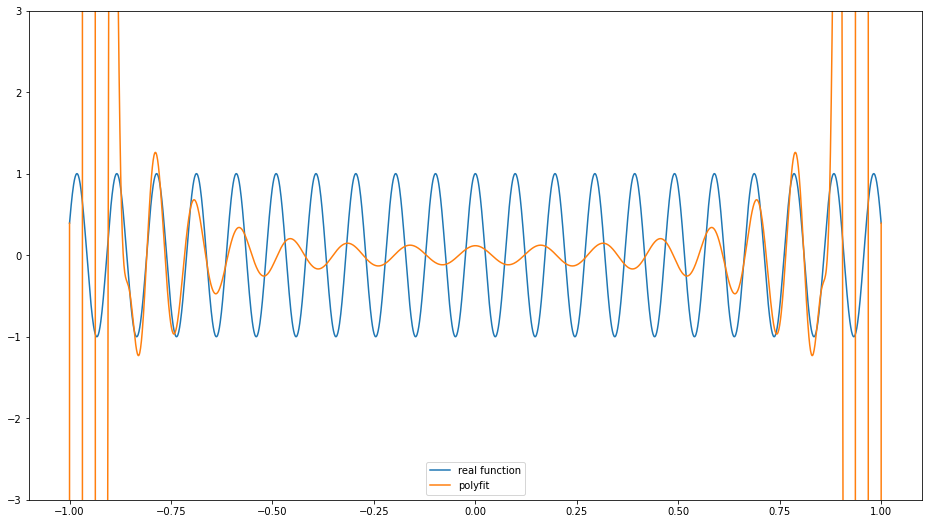

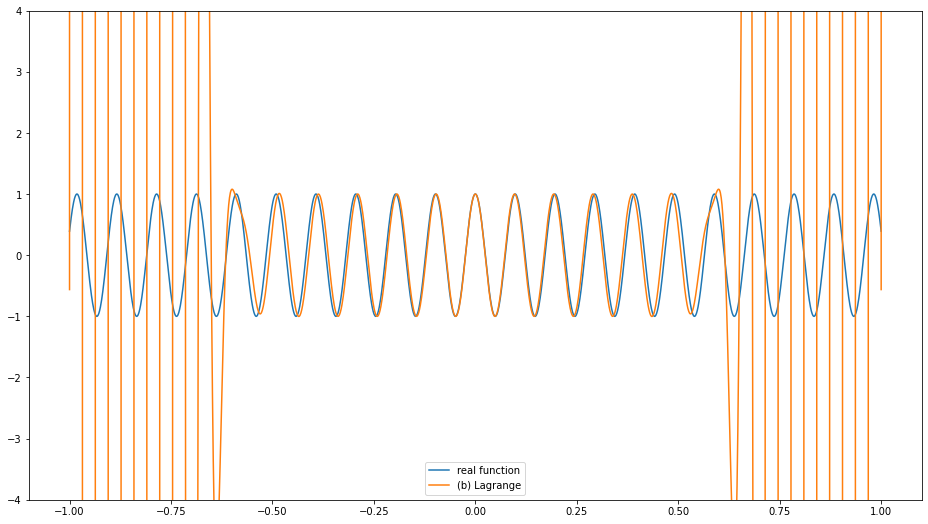

In [28]:
for n in [16, 32, 64]:
    x = np.linspace(-1, 1, n)
    y = np.cos(n * x)

    xx = np.linspace(-1, 1, 2000)
    yy = np.cos(n * xx)
    y = np.polyval(np.polyfit(x, y, n), xx)

    plt.figure(figsize=(16, 9))
    plt.ylim(-4, 4)
    plt.plot(xx, yy, label="real function")
    plt.plot(xx, y, label="(a) polyfit")
    plt.legend(loc='best')
    plt.show()

    y = np.cos((n + 1) * x)

    plt.figure(figsize=(16, 9))
    plt.ylim(-4, 4)
    plt.plot(xx, yy, label="real function")
    plt.plot(xx, LagrangeInterpolator(x, y)(xx), label="(b) Lagrange")
    plt.legend(loc='best')
    plt.show()

5

In [29]:
from scipy.optimize import curve_fit

In [30]:
def y1(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x ** 2 + p3 * x ** 3 + p4 * x ** 4 + p5 * x ** 5

def y2(x, p0, p1, p2, p3, q1, q2):
    return (p0 + p1 * x + p2 * x ** 2 + p3 * x ** 3) / (1 + q1 * x + q2 * x ** 2)

In [33]:
with np.load("data_7_1.npz") as data:
    x4, y4 = data["x4"], data["y4"]

In [34]:
popt1, pcov1 = curve_fit(y1, x4, y4)
popt2, pcov2 = curve_fit(y2, x4, y4)

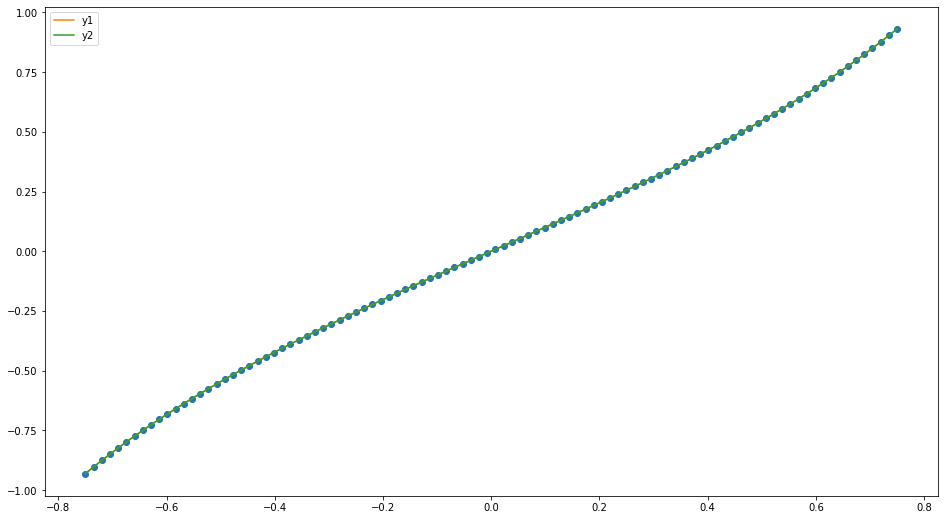

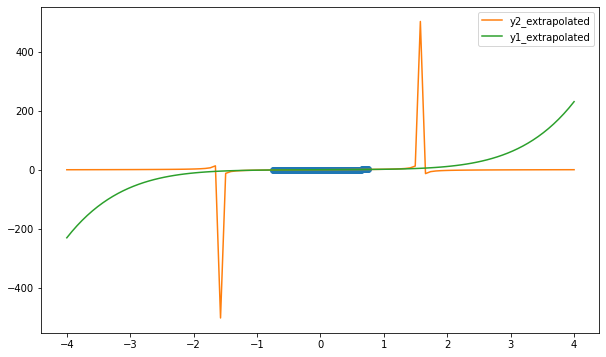

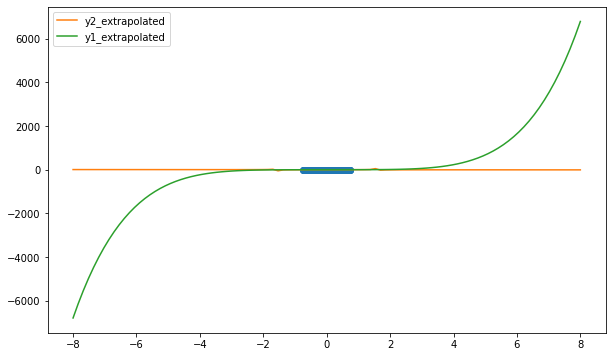

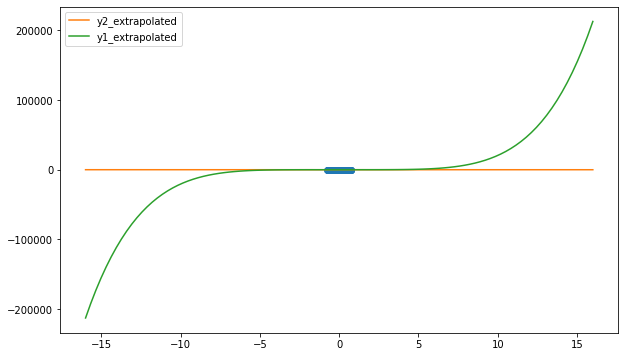

In [41]:
plt.figure(figsize=(16, 9))
plt.plot(x4, y4, "o")
p0, p1, p2, p3, p4, p5 = popt1
plt.plot(x4, y1(x4, p0, p1, p2, p3, p4, p5), label="y1")
p0, p1, p2, p3, q1, q2 = popt2
plt.plot(x4, y2(x4, p0, p1, p2, p3, q1, q2), label="y2")

plt.legend(loc='best')
plt.show()

for f in [2, 4, 8]:
    x = np.linspace(-2 * f, 2 * f, 100)
    plt.figure(figsize=(10, 6))
    plt.plot(x4, y4, "o")
    plt.plot(x, y2(x, p0, p1, p2, p3, q1, q2), label="y2_extrapolated")
    p0, p1, p2, p3, p4, p5 = popt1
    plt.plot(x, y1(x, p0, p1, p2, p3, p4, p5), label="y1_extrapolated")

    plt.legend(loc='best')
    plt.show()

7

In [70]:
def create_sys(h, y):
    n = len(y)
    matr = np.zeros((n, n))
    rhs = np.zeros(n)
    for i in range(n):
        matr[i][i - 1] = h[i - 1]
        matr[i][i] = 2 * (h[i] + h[i - 1])
        if i+1 == n:
            matr[i][0] = h[i]
            rhs[i] = 3 * ((y[0] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1])
        else:
            matr[i][i+1] = h[i]
            rhs[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1])

    return matr, rhs

In [ ]:
def my_spline(x, y):
    n = len(x)
    a, b, d = np.array(y), np.zeros(n), np.zeros(n)
    h = np.zeros(n)
    for i in range(n):
        h[i] = (x[(i + 1) % n] - x[i])
    matr, rhs = create_sys(h, y)
    c = np.linalg.solve(matr, rhs)

    for i in range(n):
        d[i] = (c[(i + 1) % n] - c[i]) / (3 * h[i])
        b[i] = (a[(i + 1) % n] - a[i]) / h[i] - h[i] * (c[(i + 1) % n] + 2 * c[i]) / 3
    return a, b, c, d

In [92]:
x = np.linspace(1, 10, 20)
y = np.tan(x) * np.exp(x) - x

In [100]:
def spline_plot(x, y):
    plt.figure(figsize=(16, 9))
    a, b, c, d = my_spline(x, y)
    n = len(x)
    for i in range(n - 1):
        xx = np.linspace(x[i], x[i + 1], 5)
        yy = a[i] + b[i] * (xx - x[i]) + c[i] * (xx - x[i])**2 + d[i] * (xx - x[i])**3
        plt.plot(xx, yy, label='s_'+str(i))

    plt.plot(x, y, 'o', label='data')

    plt.legend(loc='best')
    plt.show()

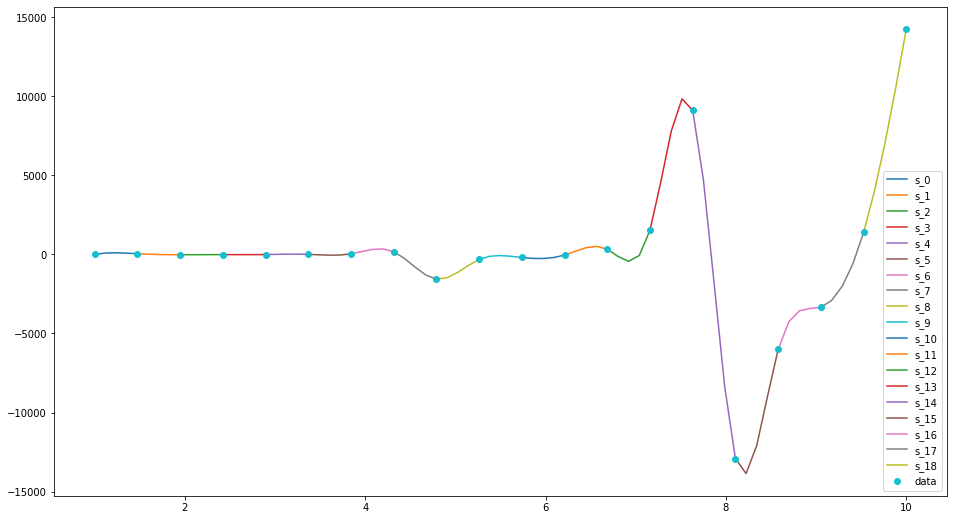

In [101]:
spline_plot(x, y)